## (Not using any form of integration)

# Modulación LoRa - Notebook conceptual

## Concepto Principal

La modulación LoRa es una de las maneras de transmitir mensajes digitales a través de técnicas de modulación de **espectro expandido**. $^1$ 

Específicamente, este tipo de modulación es una técnica de espectro expandido con codificación a base de chirps (CSS). **Un chirp** es aquella señal en la cual va aumentando o disminuyendo su frecuencia a lo largo del tiempo. En este caso, se trabaja con un chirp con barrido de frecuencia lineal, por lo que la frecuencia instantánea será de la forma:

 $y = b + m\cdot t$

Para luego transmitir la señal como una exponencial compleja, modulada en fase en función de la acumulación de frecuencia instantánea:

$y(t) = c \cdot e^{2\pi f(t)\cdot t}$

### Distinguiendo símbolos

La manera que tiene LoRa de diferenciar entre símbolos radica simplemente en definir a la ordenada al origen de cierta forma para que esté en función del símbolo a enviar, haciendo que este esté implicito en la forma de onda resultante. La completa definición se verá en la sección del desarrollo matemático.

$^1$ La modulación de espectro expandido es aquel tipo de modulación en el cual la señal a transmitir está dispersa en el campo de la frecuencia en mayor medida de la necesaria para transmitir información. De esta forma, se permite construir técnicas de modulación con mayor resistencia al ruido e interferencias. Además, la potencia también está mejor distribuida en estas frecuencias, asemejándose a la densidad espectral de potencia del ruido, por lo que tiene también importancia en la seguridad. Que la PSD de la señal sea bien distribuida, implica que la autocorrelación solo estará presente cuando no hay retardos en el tiempo (por ser su FT), por lo que muestrear la señal sincronizada es muy importante.




## Parámetros Externos para el MoDem

En esta sección se explorarán los parámetros que definen como funcionará nuestro MoDem LoRa.

- Spreading Factor ($SF$): El factor de expansión de una modulación LoRa por sí mismo solo define explícitamente la cantidad de bits contenidos en un símbolo. Sin embargo, su parámetro interno ($2^{SF}$) nos permitirá entender más conceptos asociados a la modulación (se aborda más adelante). Los valores típicos son: [7, 8, 9, 10, 11, 12]
- Bandwidth ($Bw$): El ancho de banda define los valores en frecuencia que limitarán al barrido del chirp y a su vez es un factor determinante en la duración de un símbolo. Los valores típicos son: [125kHz, 250kHz, 500kHz]
- Samples per Chip ($spc$): La cantidad de muestras por chip o *"trozo"* $^{2}$. Representa la cantidad de muestras que cada chip de tiempo tendrá.

$^2$ Para entneder lo que es un chip en la modulación LoRa, se puede explorar de donde se hereda su témrino, o sea de la modulación de espectro expandido de forma directa: En un sistema DSS, cada bit de información que se transmita se multiplicará por un codigo de expansión o secuencia de chips específica, que es donde sucede la expansión característica del espectro. De esta forma, para una frecuencia de llegada de bits no codificados, se tendrá una frecuencia mayor de bits codificados por la secuencia de expansión. A estos bits de mayor tamaño se los conoce como chips.

En el marco de la modulación LoRa, por cada símbolo transmitido (SF) se tendrá que computar $2^{SF}$ chips, ya que cada uno ocupará una frecuencia específica. Estos se distribuyen en el tiempo y es entonces como sucede la expansión del espectro.

Si bien uno podría objetar que la cantidad de muestras por chips cambia la cantidad de muestras computadas, esto simplemente repercute en la descripción gráfica de la señal, puesto que este parámetro **no permite que se puedan modular una mayor cantidad de símbolos**, ya que las ordenadas al origen y por lo tanto las discontinuidades del conjunto $\mathcal W$ permanecen iguales y cada una mantiene su valor original sin importar como evoluciona este parámetro.


## Parámetros Internos para el MoDem

En esta sección se abordarán los distintos parámetros de los que se hace uso en repetidas ocasiones, que se originan directamente de los parámetros ya vistos.

- $2^{SF}$: Esta potencia nos indica muchas cuestiones acerca de nuestra modulación a estudiar:
  - Número de símbolos posibles para transmitir: Una modulación LoRa podrá transmitir desde el símbolo 0 hasta el símbolo $2^{SF}-1$. 
  - Número de chips por símbolo: Son el mínimo número de chips temporales necesarios en un símbolo para poder asignarle un valor temporal a cada incremento de frecuencia. Es decir, que como mínimo en un código se tendrán $2^{SF}$ muestras.
  - Número de formas de onda posibles: Para cada símbolo habrá una forma de onda distinta a las otras. Justamente una demodulación propuesta (ineficiente por sus largos tiempos de cómputo) es hacer la correlación de la señal recibida con las $2^{SF}$ señales posibles, y de esa manera asumir que el símbolo recibido sea el asociado a la que logre mayor correlación.
  

- Duración de Símbolo: La duración de símbolo nos permite saber cuanto se tarda para que se complete la transmisión de un símbolo. Se define como el producto de la duración de un solo chip temporal por la cantidad de chips presentes en un símbolo, es decir:
  
  - $T_s = 2^{SF} \cdot \frac{1}{Bw} = \frac{2^{SF}}{Bw}$

- Samples per Symbol: La cantidad total de muestras por símbolo estará dada por el producto de la cantidad de chips por símbolo por la cantidad de muestras por cada chip, a saber:
  
  - $SPS = SPC \cdot 2^{SF}$

- Frequency Slope: Corresponde a la pendiente que tendrá la función frecuencia instantánea a lo largo del tiempo. Por lo tanto, se define como la tasa de cambio que esta función experimentará, quedando manifestada como lo indica la definición de *pendiente*:
  - $m = \frac{\Delta y}{\Delta t} = \frac{(Bw - 0)}{(T_{s} - 0)} = \frac{Bw}{T_{s}} = \frac{Bw^2}{2^{SF}}$

## Discretizando las Muestras de Tiempo

Sabemos por los parámetros internos que la duración de un símbolo es de:
$T_s = \frac{2^{SF}}{Bw}$
Si queremos distribuir una cantidad de muestras de manera tal que encajen correctamente a lo largo de todo el eje temporal, deberemos tener en cuenta lo siguiente:
1. Si bien la duración del símbolo es $T_s = \frac{2^{SF}}{Bw}$, la última muestra no debería bajo ningún concepto tomar este valor. Esto se debe al hecho de que esta muestra ya sería la primera del siguiente símbolo, y para evitar cualquier solapamiento es necesario tener esto en cuenta.
2. La cantidad de muestras debe ser sí o sí $2^{SF} \cdot SPC$.
3. La cantidad de muestras deben estar equiespaciadas a lo largo del tiempo. Si bien esto es trivial, la realidad es que este item será determinante a la hora de seguir el código.

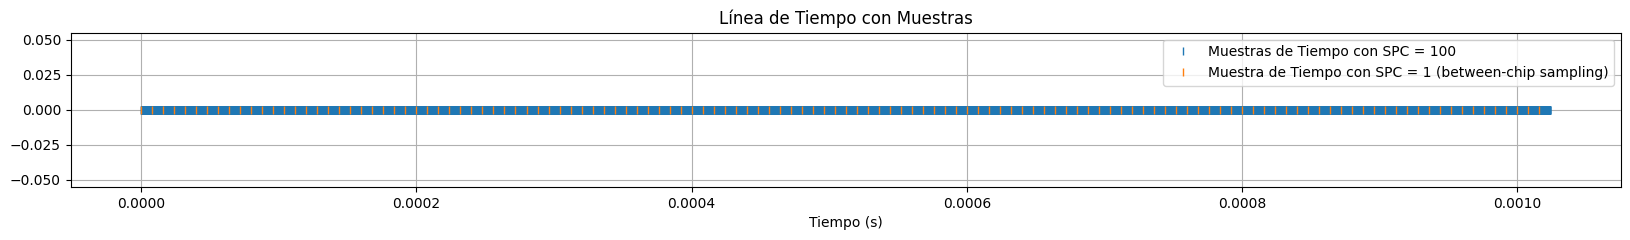

La duración del símbolo es de:  0.001024  segundos. La última muestra de tiempo es:  0.00102392  segundos.


In [2]:
# Discretizando las Muestras de Tiempo - Código de Ejemplo
import matplotlib.pyplot as plt
import numpy as np
def generate_time_samples(spreading_factor, bandwidth, samples_per_chip):
    
    # Definimos la duración de símbolo en segundos
    symbol_time = ( 2**spreading_factor ) / bandwidth

    # Definimos la cantidad de muestras por símbolo
    samples_per_symbol = int( ( 2**spreading_factor ) * samples_per_chip )

    # Generamos las muestras de tiempo (serán 129 muestras equiespaciadas, para luego sacar la última, asi logramos el punto 1 y punto 2 en una sola línea de código)
    # También es equivalente si establecemos el parámetro de numpy.linspace "endpoint" a False, pero de esta forma se entiende mejor el concepto.
    # La función numpy.linspace genera un vector de muestras equiespaciadas. Esto es mejor que utilizar np.arange, ya que acumula más errores de redondeo. (ver: https://numpy.org/doc/stable/reference/generated/numpy.arange.html)
    timeline = np.linspace(0, symbol_time, samples_per_symbol + 1)[:-1]

    return timeline

# ---------------------------------------------------------------------

spreading_factor, bandwidth, samples_per_chip = 7, 125e3, 100 #  Definimos los parámetros

timeline = generate_time_samples(spreading_factor, bandwidth, samples_per_chip) # Generamos las muestras de tiempo
timeline_spc_1 = generate_time_samples(spreading_factor, bandwidth, 1)

# Plotear la línea de tiempo con puntos en las muestras
plt.figure(figsize=(20, 2))
plt.plot(timeline, np.zeros_like(timeline), '|', label='Muestras de Tiempo con SPC = '+str(samples_per_chip))
plt.plot(timeline_spc_1, np.zeros_like(timeline_spc_1), '|', label='Muestra de Tiempo con SPC = 1 (between-chip sampling)')
plt.xlabel('Tiempo (s)')

plt.title('Línea de Tiempo con Muestras')
plt.legend()
plt.grid(True)
plt.show()
print("La duración del símbolo es de: ", ( 2**spreading_factor ) / bandwidth, " segundos. La última muestra de tiempo es: ", timeline[-1], " segundos.")

## Desarrollo Matemático

### Función de Frecuencia Instantánea

Para abordar el desarrollo matemático de la modulación LoRa, se partirá desde el análisis de la frecuencia a lo largo del tiempo, la cual sabemos será consecuente a la de una codificación por chirp.

Como vimos anteriormente, un chirp lineal en el tiempo será del tipo:
$f(t) = b + m\cdot t$

Sin embargo, recordando como se define la pendiente para un $SF$ y $Bw$ dado, podemos especificar la función de frecuencia como:

$m_f = \frac{Bw}{T_s}=\frac{Bw^2}{2^{SF}}$

$f(t) =  b + \frac{Bw}{T_s} \cdot t$

Además, siguiendo lo visto en la última subsección de Concepto Principal (*Distinguiendo símbolos*), sabemos que la ordenada al origen será la responsable de atribuirle un símbolo a la forma de onda creada. Esta atribución se origina al ponderar por el valor del símbolo al mínimo intervalo de frecuencia resultante entre la razón $\frac{Bw}{2^{SF}}$, escalando así el valor del símbolo a un valor característico en $[Hz]$:

$b(c) = c \cdot \frac{Bw}{2^{SF}}$

Quedando así, nuestra (*incompleta*) función de frecuencia instantánea:

$f(c, t) = c \cdot \frac{Bw}{2^{SF}} + \frac{Bw}{T_s} \cdot t$

Por último, es necesario aclarar que para una función dada de frecuencia instantánea se tendrá que contemplar los límites discutidos en la sección de parámetros internos, con respecto al parámetro *$Bw$*. Por lo tanto, se deberá *reiniciar* el valor de esta frecuencia a lo largo del tiempo una vez se alcancen estos límites ($0$ para un downchirp y $Bw$ para un upchirp o cualquier símbolo trasmitido). se introducirán a continuación distintas prácticas que resultan equivalentes:
- Función indicadora: Debido a que la función indicadora permite cambiar el valor de algo cuando una variable pertenece a un conjunto, se puede emular el funcionamiento de un condicional if empleando este recurso. De esta manera, se podría proponer una función de frecuencia instantánea sin discontinuidades y otra con discontinuidades, siendo esta última la que finalmente tendría relevancia en el MoDem:
    -   $f'(c, t) = c \cdot \frac{Bw}{2^{SF}} + \frac{Bw}{T_s} \cdot t$
    -   $f(c, t) = f'(c, t) - Bw\cdot \Chi _{ \{  f'_i(t) > Bw \} }$
- Función escalón y tiempo de discontinuidad: Algunos autores resaltan la posibilidad de emplear la nomenclatura de la teoría de señales para lograr el objetivo. Se calcula el instante a partir del cual habrá ocurrido la discontinuidad y luego se le asigna a la función, la resta de $Bw$ multiplicado por la función escalón, con un offset temporal equivalente al instante o tiempo de discontinuidad.
- Operador Módulo: Consiste en aprovechar el álgebra de la división entera, limitando siempre a que la salida esté entre 0 y el valor *modulante* (es decir, su resto). La mayoría de lenguajes de programación implementan este operador por defecto (en Python se representa con el token *%*), por lo que será la manera predilecta para este trabajo. Por lo tanto, la función resultante será:

  $f(c, t )= ( c \cdot \frac{Bw}{2^{SF}} + \frac{Bw}{T_s} \cdot t ) \mod Bw$   

Text(0.5, 1.0, 'Evolución de la Frecuencia Instantánea para el símbolo 11')

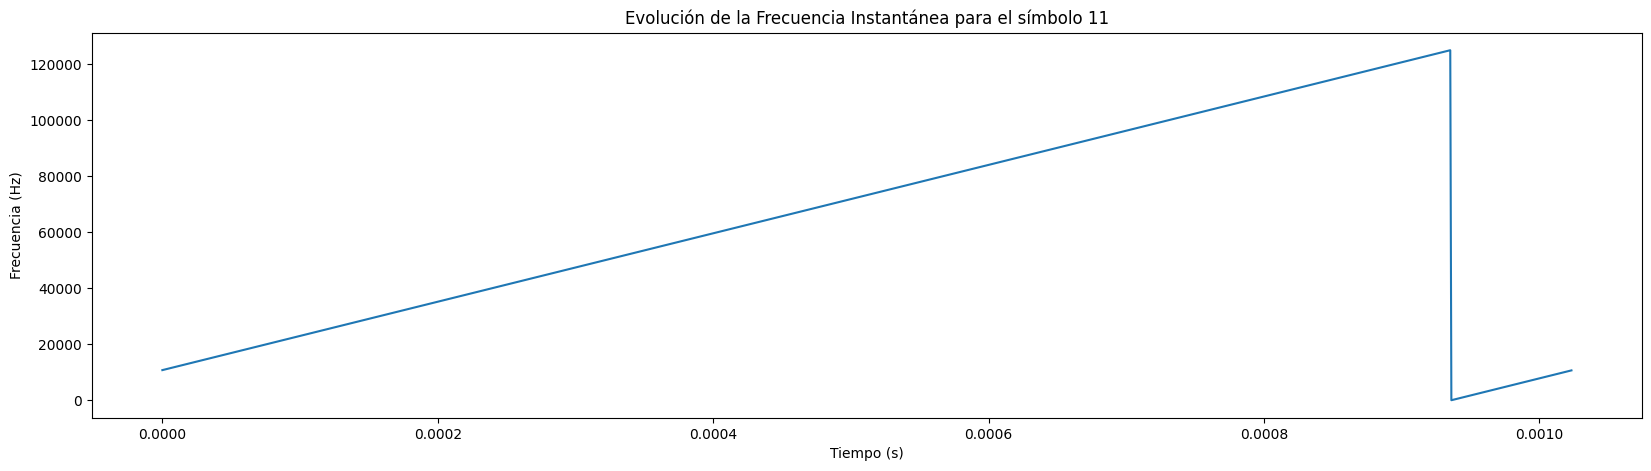

In [3]:
# Frecuencia Instantánea - Código de Ejemplo
def generate_frequency_evolution(timeline, symbol, spreading_factor, bandwidth):
    frequency_slope = bandwidth**2 / ( 2**spreading_factor )
    y_intercept = symbol * (bandwidth/2**spreading_factor)
    frequency_evolution = ( y_intercept + frequency_slope * timeline ) % bandwidth
    return frequency_evolution

# ---------------------------------------------------------------------
spreading_factor, bandwidth, samples_per_chip = 7, 125e3, 10 #  Definimos los parámetros
timeline = generate_time_samples(spreading_factor, bandwidth, samples_per_chip) # Generamos las muestras de tiempo
symbol = np.random.randint(0, 2**spreading_factor) # Definimos el símbolo a analizar
frequency_evolution = generate_frequency_evolution(timeline, symbol, spreading_factor, bandwidth) # Generamos la evolución de la frecuencia
plt.figure(figsize=(20, 5))
plt.plot(timeline, frequency_evolution)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.title('Evolución de la Frecuencia Instantánea para el símbolo ' + str(symbol))



### Señal Exponencial Compleja

Una vez se tiene la función de frecuencia instantánea resuelta, se debe traducir esta evolución de frecuencia en una portadora. Para ello, se emplea una exponencial compleja modulada en fase por esta evolución.

Partiendo de la mínima expresión de una exponencial compleja, tenemos:

$s(t) = A e^{j\cdot 2 \pi f(t) t}$


Por lo tanto, sabemos que entonces la exponencial compleja pasará a ser:

$s(t, c) = A e^{j \cdot 2 \pi f(t,c) t}$

$s(t, c) = A e^{j \cdot 2 \pi (( c \cdot \frac{Bw}{2^{SF}} + \frac{Bw}{T_s} \cdot t ) \mod Bw) t}$

Por último, podemos definir al coeficiente como:

$A = \frac{1}{\sqrt{2^{SF}\cdot SPC}}$

Y así concluir con nuestra señal resultante:

$s(t, c) = \frac{1}{\sqrt{2^{SF}\cdot SPC}} e^{j \cdot 2 \pi (( c \cdot \frac{Bw}{2^{SF}} + \frac{Bw}{T_s} \cdot t ) \mod Bw) t}$



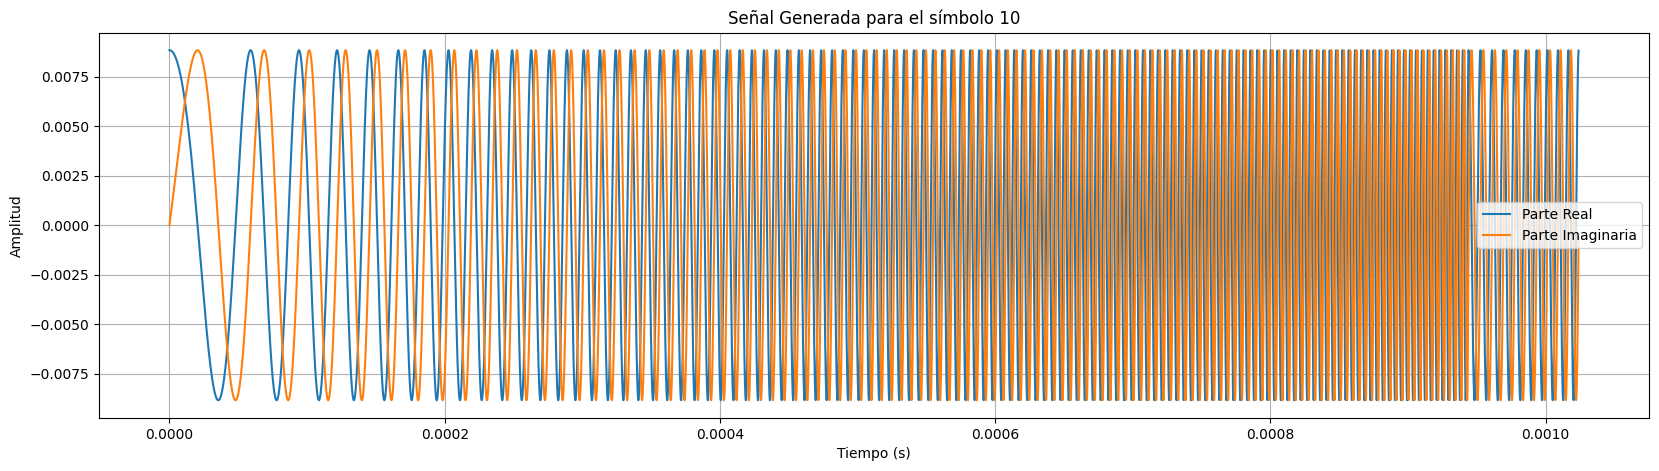

In [6]:
def generate_signal(timeline, symbol, spreading_factor, bandwidth, samples_per_chip):
    signal = np.array([])
    auxiliar_slope = ( bandwidth**2 /  2**spreading_factor )
    y_intercept = symbol * ( bandwidth / 2**spreading_factor )
    frequency_evolution = ( y_intercept + auxiliar_slope * timeline ) % bandwidth
    signal_coefficient = 1/np.sqrt(2**spreading_factor * samples_per_chip)
    instantaneous_phase = 2 * np.pi * ( (frequency_evolution * timeline)  )
    signal = signal_coefficient * np.exp(1j * instantaneous_phase) 
    
    return signal, frequency_evolution
# ---------------------------------------------------------------------
spreading_factor, bandwidth, samples_per_chip = 7, 125e3, 100 #  Definimos los parámetros
timeline = generate_time_samples(spreading_factor, bandwidth, samples_per_chip) # Generamos las muestras de tiempo
symbol = 10 # Definimos el símbolo a analizar
signal,f_test = generate_signal(timeline, symbol, spreading_factor, bandwidth, samples_per_chip) # Generamos la señal
plt.figure(figsize=(20, 5))
plt.plot(timeline, np.real(signal), label='Parte Real')
plt.plot(timeline, np.imag(signal), label='Parte Imaginaria')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Generada para el símbolo '+str(symbol))
plt.legend()
plt.grid(True)
plt.show()


## Demodulación

In [5]:
class LoraDemodulator():
    def __init__(self, sf, bw, samples_per_chip):
        self.spreading_factor = sf
        self.bandwidth = bw
        self.samples_per_chip = samples_per_chip
        self.chips_number = 2**sf
        self.symbol_duration = 2**sf / bw
        self.frequency_slope = bw / self.symbol_duration

    def generate_timeline(self, symbols_number = 1):
        '''
        This method generates a discrete timeline for the transmission of a given number of symbols.
        Parameters:
        symbols_number: number of symbols to be transmitted
        '''
        # spreading_factor: spreading factor
        # bandwidth: bandwidth
        # samples_per_chip: samples per chip

        symbol_time = (2**self.spreading_factor) / self.bandwidth

        # Number of evenly-spaced time samples.
        # A plus one has to be added in order correctly generate the timeline
        num_time_samples= (2**self.spreading_factor) * self.samples_per_chip * symbols_number + 1

        timeline =  np.linspace(0, symbol_time * symbols_number, num_time_samples)

        # Remove the last element of the timeline due to the discretization
        timeline = timeline[:-1]

        return timeline
    
    def generate_downchirp(self, also_return_freq=False):
        '''
        This function generates a downchirp signal.
        Parameters:
        also_return_freq: boolean to also return the frequency evolution of the downchirp across the timeline
        '''
        # sf: spreading factor
        # freq: frequency
        # timeline: timeline
        timeline = self.generate_timeline()
        y_intercept = self.bandwidth
        theoretical_symbol_time = (2**self.spreading_factor) / self.bandwidth
        freqs = []
        slope = -self.bandwidth / theoretical_symbol_time
        coeff = 1/(np.sqrt(2**self.spreading_factor * self.samples_per_chip))
        signal = []

        for i in range(len(timeline)):
            freq = y_intercept + slope * timeline[i]
            integrated_freq = y_intercept +  slope * timeline[i]

            inst_phase = 2 * np.pi * (integrated_freq) * timeline[i]
            signal.append( coeff * np.exp(1j * inst_phase))
            freqs.append(freq)
            
        if also_return_freq:
            return signal, freqs
        return signal
    
    def generate_upchirp(self, also_return_freq=False):
            '''
            This function generates an upchirp signal.
            Parameters:
            also_return_freq: boolean to also return the frequency evolution of the downchirp across the timeline
            '''
            # sf: spreading factor
            # freq: frequency
            # timeline: timeline
            timeline = self.generate_timeline()
            y_intercept = 0
            theoretical_symbol_time = (2**self.spreading_factor) / self.bandwidth
            freqs = []
            slope = self.bandwidth / theoretical_symbol_time
            coeff = 1/(np.sqrt(2**self.spreading_factor * self.samples_per_chip))
            signal = []

            for i in range(len(timeline)):
                freq = y_intercept + slope * timeline[i]
                integrated_freq = y_intercept + slope * timeline[i]

                inst_phase = 2 * np.pi * (integrated_freq) * timeline[i]
                signal.append( coeff * np.exp(1j * inst_phase))
                freqs.append(freq)
                
            if also_return_freq:
                return signal, freqs
            return signal
    
    def correlate_single_signal(self, signal, use_upchirp=False):
        '''
        This function correlates a signal with a downchirp signal.
        Parameters:
        signal: complex signal
        '''
        if use_upchirp:
            base_signal = self.generate_upchirp()
        else:
            base_signal = self.generate_downchirp()
        product = []
        for i in range(len(signal)):
            product.append(signal[i] * base_signal[i])

        fourier_transform = np.fft.fft(product)
        return fourier_transform
    
    def demodulate_single_symbol(self, signal, return_fft=False, use_upchirp=False):
        '''
        This function demodulates a signal.
        Parameters:
        signal: complex signal
        '''
        fourier_transform = self.correlate_single_signal(signal, use_upchirp)
        max_index = np.argmax(fourier_transform) % 2**self.spreading_factor
        if return_fft:
            return max_index, fourier_transform
        return max_index
    

    def demodulate_multiple_symbols(self, signal):
        '''
        This function demodulates a signal with multiple symbols.
        Parameters:
        signal: complex signal
        '''
        symbols = []
        samples_per_symbol = self.chips_number * self.samples_per_chip

        for i in range(0, len(signal), samples_per_symbol):
            symbol = self.demodulate_single_symbol(signal[i : i + samples_per_symbol])
            symbols.append(symbol)
        return symbols

    def generate_demodulation_plots(self, signal, fft = None):
        '''
        This function generates the plots for a graphical representation of the demodulation process.
        '''
        subplots = 1
        if fft is not None:
            subplots = 2
        
        figure, axes = plt.subplots(subplots, 1, figsize=(20, 12))
        figure.suptitle('LoRa Demodulation', fontsize=20)

        axes[0].plot(np.real(signal))
        axes[0].plot(np.imag(signal))
        axes[0].set_title('Real and imaginary parts of the received signal')
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Amplitude')

        if fft is not None:
            observed_symbol = np.argmax(fft) % 2**self.spreading_factor
            axes[1].plot(fft)
            axes[1].set_title('Fourier Transform of the correlation between the received signal and the downchirp. The observed symbol is: '+str(observed_symbol))
            axes[1].set_xlabel('Frequency (Hz)')
            axes[1].set_ylabel('Amplitude')


        return figure

        